In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
img1 = cv2.cvtColor(cv2.imread('InputImages/Sun/1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('InputImages/Sun/2.jpg'), cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread('InputImages/Sun/3.jpg'), cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread('InputImages/Sun/4.jpg'), cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(cv2.imread('InputImages/Sun/5.jpg'), cv2.COLOR_BGR2RGB)

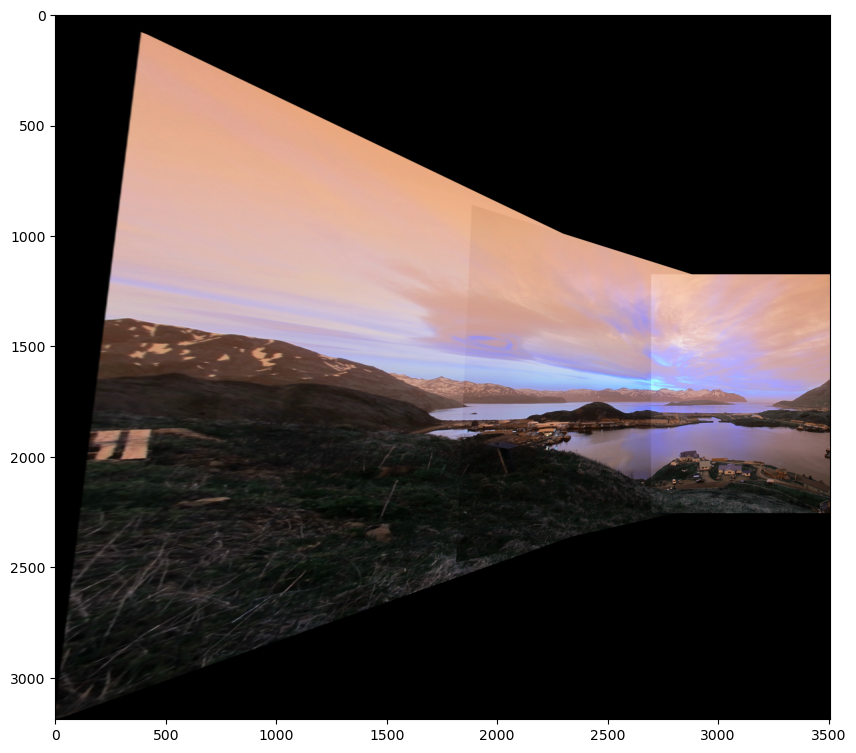

In [18]:
sift = cv2.SIFT_create()

img = [img1, img2, img3]
stitched_image = img[0]

bf = cv2.BFMatcher()
for i in range(len(img)-1):
    kp1, des1 = sift.detectAndCompute(stitched_image, None)
    kp2, des2 = sift.detectAndCompute(img[i+1], None)
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # Extract the matched keypoints
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

    h1, w1 = stitched_image.shape[:2]
    h2, w2 = img[i+1].shape[:2]
    corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)  # each corner is represented as [[x, y]]     
    corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

    transformed_corners = cv2.perspectiveTransform(corners1, H)                     # only corners 1 undergo transformation
    transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)   # concatenate arrs along the rows

    # Find the minimum and maximum (transformed) coordinates to get the dimensions of the panoramic image
    min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())                # finding the min & max along the first axis -- (x, y) coordinates
                                                                                    # ravel() -- flattens the array results
    max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())

    # Adjust the homography matrix to account for the shift
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])      # shifting the image by -minx_x & min_y (so that it starts from (0, 0))
    adjusted_homography_matrix = np.dot(translation_matrix, H)                      # apply translation to the original homography matrix H

    # Apply the adjusted homography to warp the image
    stitched_image = cv2.warpPerspective(stitched_image, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
    stitched_image[-min_y:img[i+1].shape[0] - min_y, -min_x:img[i+1].shape[1] - min_x,:] = img[i+1]    # overlays img[i+1] onto the stitched image, ensuring that it aligns properly with img[i]
                                                                                                # the negative indexing is used to ensure correct placement of img[i+1] in the stitched image.

    # Display or save the stitched image
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))

